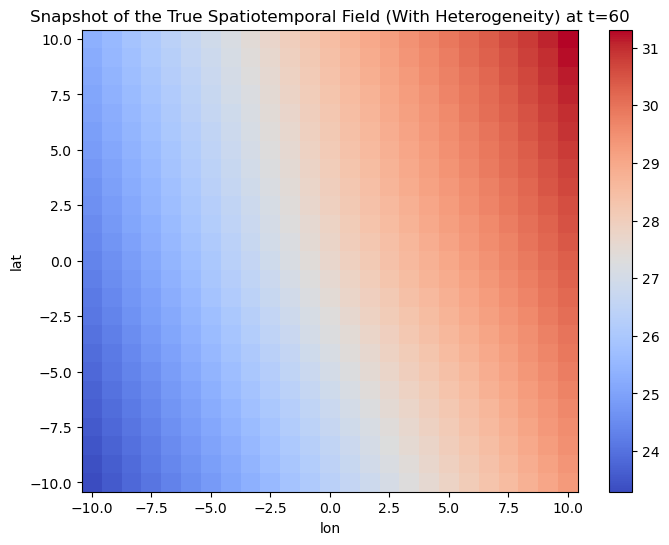

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel, ConstantKernel as C

np.random.seed(42)  # For reproducibility

# Define latitude, longitude, and time coordinates
n_days = 200  # Total time points
grid_size = 25

lat_coords = np.linspace(-10, 10, grid_size)  # Latitude range
lon_coords = np.linspace(-10, 10, grid_size)  # Longitude range
time_feature = np.arange(1, n_days + 1)  # Time

# Function to compute a spatially heterogeneous synthetic field with lat, lon, and time
def synthetic_space_time_function(lat, lon, t):
    # Propagating pulse with spatial variation
    pulse_center_lat = 0.0 + 0.05 * t  # Moving pulse in latitude
    pulse_center_lon = 0.0
    pulse_width = 5.0
    spatial_distance = np.sqrt((lat - pulse_center_lat) ** 2 + (lon - pulse_center_lon) ** 2)
    pulse = 15 * np.exp(-(spatial_distance ** 2) / (2 * pulse_width ** 2)) * np.sin(2 * np.pi * t / 30)
    
    # Heterogeneity: add spatial variations (e.g., linear trends in latitude/longitude)
    spatial_heterogeneity = (0.1 * lat + 0.3 * lon)  # Spatial trend
    
    # Seasonal variability (constant across space)
    seasonal_variability = 10 * np.sin(2 * np.pi * t / (365.25 * 0.2))
    
    # Interannual variability (constant across space)
    interannual_variability = 5 * np.sin(2 * np.pi * t / (365.25 * 5))
    
    # Add linear temporal trend
    trend = 0.05 * t
    
    return 20 + trend + seasonal_variability + interannual_variability + pulse + spatial_heterogeneity

# Create synthetic data over lat/lon/time
space_time_grid = xr.DataArray(
    np.zeros((n_days, len(lat_coords), len(lon_coords))),
    coords=[time_feature, lat_coords, lon_coords],
    dims=["time", "lat", "lon"]
)

# Fill the synthetic data array
for t in range(n_days):
    for i, lat in enumerate(lat_coords):
        for j, lon in enumerate(lon_coords):
            space_time_grid[t, i, j] = synthetic_space_time_function(lat, lon, time_feature[t])

# Visualize a snapshot of the synthetic spatiotemporal field
plt.figure(figsize=(8, 6))
space_time_grid.mean("time").plot(cmap="coolwarm")
plt.title("Snapshot of the True Spatiotemporal Field (With Heterogeneity) at t=60")
plt.show()


In [2]:
# ------------------------------
# Function 1: Generate Random Buoy Locations
# ------------------------------
def generate_random_buoy_locations(n_buoys, lat_range, lon_range):
    buoy_locs = np.column_stack((
        np.random.uniform(low=lat_range[0], high=lat_range[1], size=n_buoys),
        np.random.uniform(low=lon_range[0], high=lon_range[1], size=n_buoys)
    ))
    return buoy_locs

# ------------------------------
# Function 2: Extract Buoy Data from the Spatiotemporal Field
# ------------------------------
def extract_buoy_data(space_time_grid, buoy_locs, time_feature):
    n_days = len(time_feature)
    n_buoys = len(buoy_locs)
    buoy_data = xr.DataArray(
        np.zeros((n_days, n_buoys)),
        coords=[time_feature, np.arange(n_buoys)],
        dims=["time", "buoy"]
    )
    for b, (lat, lon) in enumerate(buoy_locs):
        buoy_data[:, b] = space_time_grid.sel(lat=lat, lon=lon, method="nearest").values
    return buoy_data

# ------------------------------
# Function 3: Add Noise to Buoy Data
# ------------------------------
def add_noise_to_buoy_data(buoy_data, noise_scale):
    noisy_buoy_data = buoy_data.copy()
    noisy_buoy_data += np.random.normal(0, noise_scale, size=noisy_buoy_data.shape)
    return noisy_buoy_data

# ------------------------------
# Function 4: Calculate Anomalies (Analysis)
# ------------------------------
def calculate_anomalies(buoy_data):
    """
    Calculate anomalies by subtracting the mean of each buoy's time series.
    
    Parameters:
        buoy_data (xr.DataArray): The buoy data.
    
    Returns:
        xr.DataArray: The anomalies (buoy_data - mean of each buoy).
    """
    mean_buoy_data = buoy_data.mean(dim='time')
    anomalies = buoy_data - mean_buoy_data
    return anomalies

# ------------------------------
# Function 4: Plot Buoy Data (Optional Utility)
# ------------------------------
def plot_buoy_data(buoy_data, buoy_locs, title="Buoy Data Over Time"):
    """
    Plots buoy data over time for each buoy.
    
    Parameters:
        buoy_data (xr.DataArray): Buoy data (n_days, n_buoys).
        buoy_locs (np.ndarray): Array of buoy locations (lat, lon) with shape (n_buoys, 2).
        title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    for b in range(buoy_data.shape[1]):
        plt.plot(buoy_data.time, buoy_data[:, b], label=f"Buoy {b} (Lat: {buoy_locs[b, 0]:.2f}, Lon: {buoy_locs[b, 1]:.2f})")
    plt.title(title)
    plt.xlabel("Time (Days)")
    plt.ylabel("Temperature")
    plt.legend()
    plt.show()
    
# ------------------------------
# Function 5: Perform GPR Reconstruction (Analysis)
# ------------------------------
def gpr_reconstruction(buoy_anomalies, buoy_locs, missing_time_start, missing_time_end, time_feature, target_buoy, kernel=None):
    """
    Perform Gaussian Process Regression (GPR) to reconstruct missing data, excluding the target buoy's missing gap.
    
    Parameters:
        buoy_anomalies (xr.DataArray): Anomalies from the buoy data.
        buoy_locs (np.ndarray): Locations of the buoys (lat, lon).
        missing_time_start (int): Start of the missing data gap.
        missing_time_end (int): End of the missing data gap.
        time_feature (np.ndarray): Array of time points.
        target_buoy (int): Index of the target buoy.
        kernel (sklearn kernel): Custom kernel for GPR (optional).
    
    Returns:
        np.ndarray: GPR reconstructed anomalies and their uncertainties.
    """
    if kernel is None:
        kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[1.0, 1.0, 1.0], length_scale_bounds=(1e-2, 1e3), nu=2.5) + WhiteKernel(noise_level=0.2, noise_level_bounds=(1e-5, 0.5))
    
    # Prepare GPR training data using anomalies from all buoys (excluding missing data from target buoy)
    X_train_full = []
    y_train_full = []

    for b, (lat, lon) in enumerate(buoy_locs):
        lat_np = np.full((len(time_feature), 1), lat)
        lon_np = np.full((len(time_feature), 1), lon)
        time_np = time_feature.reshape(-1, 1)
        
        X_train_buoy = np.hstack([lat_np, lon_np, time_np])
        y_train_buoy = buoy_anomalies[:, b].values
        
        if b == target_buoy:
            # Only use non-missing data from the target buoy
            observed_indices = np.ones(len(time_feature), dtype=bool)
            observed_indices[missing_time_start:missing_time_end] = False
            X_train_full.append(X_train_buoy[observed_indices])
            y_train_full.append(y_train_buoy[observed_indices])
        else:
            X_train_full.append(X_train_buoy)
            y_train_full.append(y_train_buoy)

    X_train_full = np.vstack(X_train_full)
    y_train_full = np.concatenate(y_train_full)
    
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, alpha=0, normalize_y=False)
    gp.fit(X_train_full, y_train_full)

    # Prepare the test set (predict the full time series for the target buoy, including missing part)
    lat_target = np.full((len(time_feature), 1), buoy_locs[target_buoy, 0])
    lon_target = np.full((len(time_feature), 1), buoy_locs[target_buoy, 1])
    X_target = np.hstack([lat_target, lon_target, time_feature.reshape(-1, 1)])

    # GPR prediction for the target buoy (including the missing gap)
    y_pred_full, y_std_full = gp.predict(X_target, return_std=True)
    
    return y_pred_full, y_std_full


# ------------------------------
# Step 5: Remove Data from the Target Buoy Before GPR (Simulate Missing Data)
# ------------------------------
def simulate_missing_data(buoy_anomalies, target_buoy, missing_time_start, missing_time_end):
    """
    Simulate missing data by setting the specified time range to NaN for the target buoy.
    
    Parameters:
        buoy_anomalies (xr.DataArray): Anomalies from the buoy data.
        target_buoy (int): Index of the target buoy.
        missing_time_start (int): Start of the missing data.
        missing_time_end (int): End of the missing data.
    
    Returns:
        xr.DataArray: Buoy anomalies with missing data in the target buoy.
    """
    buoy_anomalies_with_gap = buoy_anomalies.copy()
    buoy_anomalies_with_gap[missing_time_start:missing_time_end, target_buoy] = np.nan
    return buoy_anomalies_with_gap


# ------------------------------
# Step 6: Compare Reconstruction with True Original Data and GPR
# ------------------------------
def compare_reconstruction(true_anomalies, noisy_data_with_gap, gpr_reconstructed, 
                           target_buoy, time_feature, missing_time_start, missing_time_end):
    """
    Compare the original data, noisy data (with gaps), and GPR reconstructed anomalies.
    
    Parameters:
        true_anomalies (xr.DataArray): True anomaly field.
        noisy_data_with_gap (xr.DataArray): Noisy data with gaps.
        gpr_reconstructed (np.ndarray): GPR reconstructed anomalies.
        target_buoy (int): The target buoy index.
        time_feature (np.ndarray): Array of time points.
        missing_time_start (int): Start of the missing data gap.
        missing_time_end (int): End of the missing data gap.
    """
    plt.figure(figsize=(12, 6))
    
    # Plot true anomalies (before adding gaps)
    plt.plot(time_feature, true_anomalies[:, target_buoy], label="True Original Anomalies", color="green")
    
    # Plot noisy data with the missing gap
    plt.plot(time_feature, noisy_data_with_gap[:, target_buoy], label="Noisy Data (With Gaps)", color="blue", linestyle='--')
    
    # Plot GPR reconstructed anomalies
    plt.plot(time_feature, gpr_reconstructed, label="GPR Reconstructed Anomalies", color="orange")
    
    # Highlight the gap
    plt.axvspan(missing_time_start, missing_time_end, color='red', alpha=0.3, label="Missing Data Gap")
    
    plt.title("Comparison: True Original Data, Noisy Data (With Gap), and GPR Reconstructed Data")
    plt.xlabel("Time (Days)")
    plt.ylabel("Temperature Anomalies")
    plt.legend()
    plt.show()


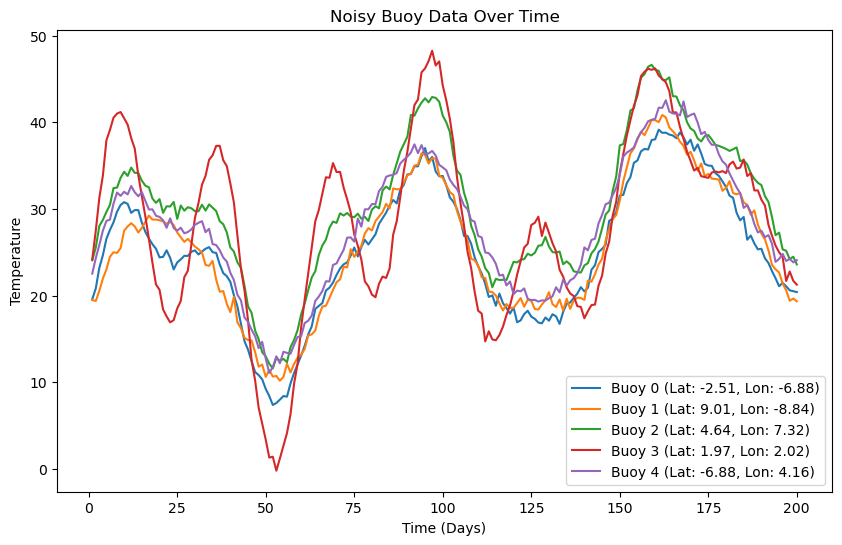

In [3]:
# ------------------------------
# Example Usage: Putting It All Together
# ------------------------------

# Parameters
n_buoys = 5  # Number of buoys to generate
lat_range = (lat_coords[0], lat_coords[-1])  # Latitude range
lon_range = (lon_coords[0], lon_coords[-1])  # Longitude range

time_feature = np.arange(1, n_days + 1)
noise_scale = 0.5
missing_time_start = 50
missing_time_end = 100
target_buoy = 0

# Assume you already have the 'space_time_grid' (spatiotemporal field)

# Step 1: Generate Random Buoy Locations
random_buoy_locs = generate_random_buoy_locations(n_buoys, lat_range, lon_range)

# Step 2: Extract Buoy Data from the Spatiotemporal Field
buoy_data = extract_buoy_data(space_time_grid, random_buoy_locs, time_feature)

# Step 3: Add Noise to the Buoy Data
noisy_buoy_data = add_noise_to_buoy_data(buoy_data, noise_scale)

plot_buoy_data(noisy_buoy_data, random_buoy_locs, title="Noisy Buoy Data Over Time")

In [4]:
random_buoy_locs

array([[-2.50919762, -6.88010959],
       [ 9.01428613, -8.83832776],
       [ 4.63987884,  7.32352292],
       [ 1.97316968,  2.02230023],
       [-6.87962719,  4.16145156]])

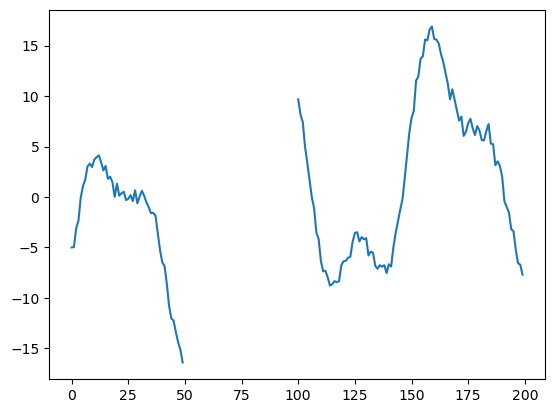

In [25]:
# Step 4: Calculate Anomalies
buoy_anomalies = calculate_anomalies(noisy_buoy_data)

# Step 5: Simulate Missing Data in the Target Buoy
buoy_anomalies_with_gap = simulate_missing_data(buoy_anomalies, target_buoy, missing_time_start, missing_time_end)

plt.plot(buoy_anomalies_with_gap[:, 0])

/Users/anthonymeza/miniforge3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


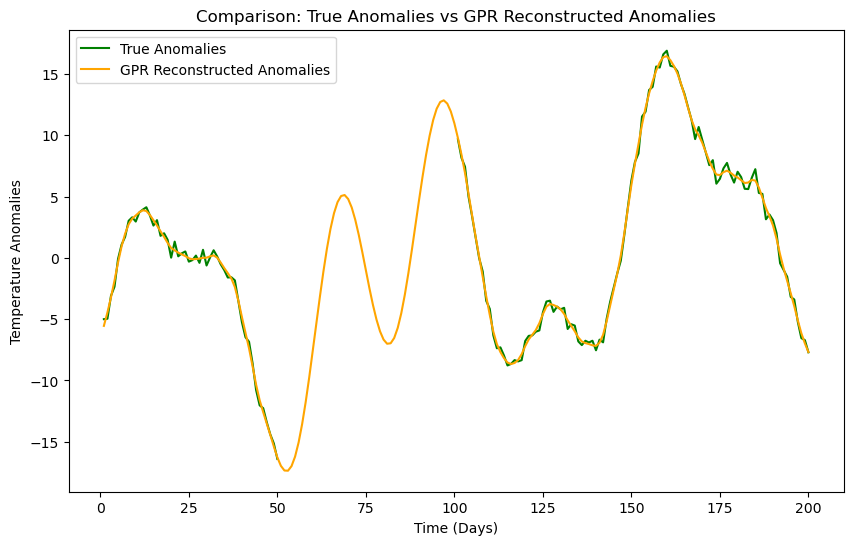

In [27]:
# Step 5: Perform GPR Reconstruction
y_pred_full, y_std_full = gpr_reconstruction(buoy_anomalies_with_gap, random_buoy_locs, missing_time_start, missing_time_end, time_feature, target_buoy)

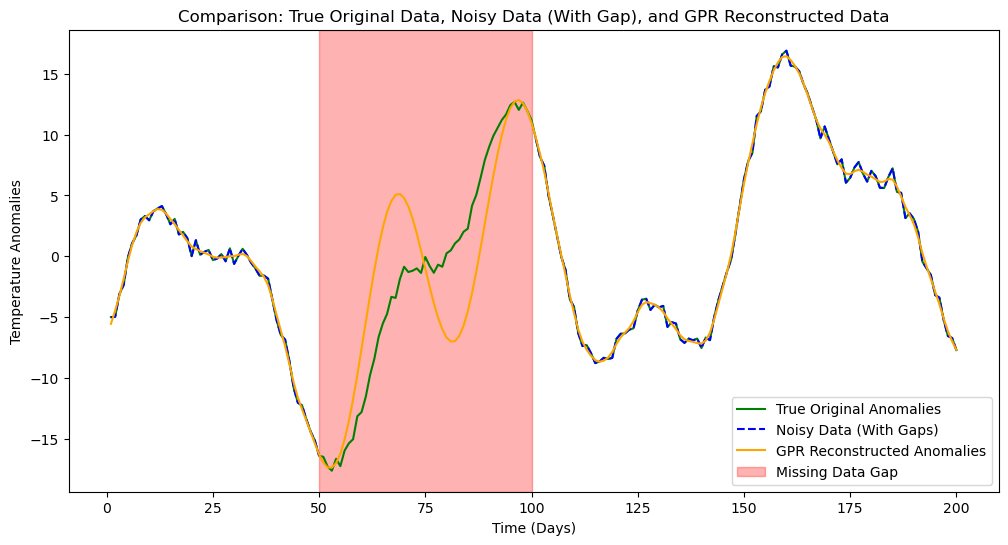

In [32]:
# Step 6: Compare Reconstruction
compare_reconstruction(buoy_anomalies, buoy_anomalies_with_gap, y_pred_full, target_buoy, time_feature, missing_time_start, missing_time_end)
